In [2]:
# show more than one output in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [3]:
from torchvision import models as tvm
import pretrainedmodels as ptm
models = (
#     ptm.alexnet, # gets maximum recursion limit exceeded exceptions
#     ptm.nasnetalarge, # calculated output size is too small
    ptm.se_resnet50,
    ptm.se_resnet101,
    ptm.inceptionresnetv2,
    ptm.inceptionv4,
    ptm.vgg16,
    ptm.vgg19,
    tvm.resnet101,
    ptm.senet154,
)

DATA_DIR = 'data/4_class_11'

domain = [
#     {'name': 'model_num', 'type': 'discrete', 'domain': range(len(models))},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (16, 24, 32, 48, 64)},
    {'name': 'adam_lr', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'adam_beta1', 'type': 'continuous', 'domain': (0.8, .99)},
    {'name': 'adam_beta2', 'type': 'continuous', 'domain': (0.95, .9999)},
    {'name': 'adam_wtdecay', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'epochs', 'type': 'discrete', 'domain': (10, 20, 30, 40)}
]
#default_input = [3, 32, 0.001, 0.9, 0.999, 0, 30] # TODO: have to figure out how to do this

In [4]:
model_num = 0

def f(x):
    """ Value function to minimize for bayesian optimization """
    val_acc = train(
        model_num,
        batch_size=int(x[:,0]),
        adam_lr=float(x[:,1]),
        adam_b1=float(x[:,2]),
        adam_b2=float(x[:,3]),
        adam_wtdecay=float(x[:,4]),
        epochs=int(x[:,5])
    )
    
    return -val_acc


NUM_CLASSES = 4


def prepare_model(model_num):
    model_fn = models[model_num]
    if model_fn is tvm.resnet101:
        # torchvision models
        pretrained = True
        last = 'fc'
    else:
        # pretrainedmodels package specific differences
        pretrained = 'imagenet'
        last = 'last_linear'
    image_size = 299 if 'inception' in str(model_fn).lower() else 224
    
    model = model_fn(num_classes=1000, pretrained=pretrained)
    num_in = getattr(model, last).in_features
    setattr(model, last, torch.nn.Linear(num_in, NUM_CLASSES))
    return model, image_size


import os
from train import prepare_results_file
import torch
from torch.optim import Adam
from torch.nn import  CrossEntropyLoss
from src.trainable import Trainable
from src.utils import get_datasets_and_loaders

iteration = 0
def train(model_num, batch_size, adam_lr, adam_b1, adam_b2, adam_wtdecay, epochs):
    global iteration
    iteration += 1
    print("\nITERATION", iteration)
    print(f'model: {str(models[model_num]).split()[1]}, batch_size: {batch_size}, epochs: {epochs}')
    print(f'adam_lr: {adam_lr}, adam_b1: {adam_b1}, adam_b2: {adam_b2}, adam_wtdecay: {adam_wtdecay}')

    model, image_size = prepare_model(model_num)
    
    _, dataloaders = get_datasets_and_loaders(DATA_DIR, 'train', 'val', 
                                              image_size=image_size)
    
    optimizer = Adam(model.parameters(), adam_lr, (adam_b1, adam_b2), adam_wtdecay)
    criterion = CrossEntropyLoss()
    
    trainable = Trainable(model, criterion, optimizer)
    
    params = '_'.join([str(batch_size)] + [f'{param:4f}' for param in (adam_lr, adam_b1, adam_b2, adam_wtdecay)] + [str(epochs)])
    results_fp = os.path.join("experiments", "bayes_opt", f'model_{model_num}', DATA_DIR, params + '.csv')
#     print(results_fp)
    prepare_results_file(results_fp)
    try:
        val_acc = trainable.train(dataloaders, epochs, early_stop=5, results_filepath=results_fp, verbose=False)
    except Exception as e:
        if iteration > 1:
            raise e
        print(e)
        val_acc = 0
    return val_acc
    

In [5]:
# # TEST CODE
# train(model, 4, 1e-3, 0.9, 0.999, 0, 50)

## Do BO on all models on both datasets. Git push at each stage

DATA/DIE_VS_ALL_11

ITERATION 1
model: se_resnet50, batch_size: 24, epochs: 30
adam_lr: 0.02370457526841632, adam_b1: 0.9450172252169783, adam_b2: 0.9646318888432945, adam_wtdecay: 0.1480112493010346


Training stopped early at 16 epochs.
Training completed in 5m 58s
Best validation accuracy: 0.8821
Associated train accuracy: 0.8856
Associated train loss: 0.2620

ITERATION 2
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.09713396732844995, adam_b1: 0.8333262710582154, adam_b2: 0.9581273511298187, adam_wtdecay: 0.23089437900129883


Training stopped early at 8 epochs.
Training completed in 2m 57s
Best validation accuracy: 0.8491
Associated train accuracy: 0.7834
Associated train loss: 0.4953

ITERATION 3
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.01774092181257922, adam_b1: 0.8023178236083797, adam_b2: 0.9550406961243072, adam_wtdecay: 0.20127970696910236


Training stopped early at 8 epochs.
Training completed in 2m 58s
Best validation accuracy: 0.8774
Associated train accuracy: 0.8573
Associated train loss: 0.3611

ITERATION 4
model: se_resnet50, batch_size: 16, epochs: 10
adam_lr: 0.0561829154872471, adam_b1: 0.8491116253623031, adam_b2: 0.9532750947044442, adam_wtdecay: 0.7074290693021308


Training stopped early at 10 epochs.
Training completed in 3m 41s
Best validation accuracy: 0.8915
Associated train accuracy: 0.8370
Associated train loss: 0.3649

ITERATION 5
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.006393963352297463, adam_b1: 0.8864641571767667, adam_b2: 0.9836196033850413, adam_wtdecay: 0.0761978585078058


Training stopped early at 16 epochs.
Training completed in 5m 54s
Best validation accuracy: 0.9151
Associated train accuracy: 0.8927
Associated train loss: 0.2502

ITERATION 6
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.0016188818009900672, adam_b1: 0.8915598067028814, adam_b2: 0.9779573832352425, adam_wtdecay: 0.05057473653784478


Training stopped early at 20 epochs.
Training completed in 7m 27s
Best validation accuracy: 0.9104
Associated train accuracy: 0.9079
Associated train loss: 0.2324

ITERATION 7
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.03917286973282196, adam_b1: 0.9097726158025985, adam_b2: 0.971048637779205, adam_wtdecay: 0.11614836788716693


Training stopped early at 8 epochs.
Training completed in 2m 58s
Best validation accuracy: 0.8396
Associated train accuracy: 0.8249
Associated train loss: 0.4268

ITERATION 8
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.001, adam_b1: 0.8806180312730623, adam_b2: 0.9866419270540859, adam_wtdecay: 0.06463697055370814


Training stopped early at 19 epochs.
Training completed in 7m 2s
Best validation accuracy: 0.9245
Associated train accuracy: 0.9130
Associated train loss: 0.2136

ITERATION 9
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.001, adam_b1: 0.8611614688082462, adam_b2: 0.9941934119793356, adam_wtdecay: 0.06650862048810066


Training stopped early at 15 epochs.
Training completed in 5m 33s
Best validation accuracy: 0.9104
Associated train accuracy: 0.9160
Associated train loss: 0.2200

ITERATION 10
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.001, adam_b1: 0.8876474027672132, adam_b2: 0.9999, adam_wtdecay: 0.06332236518843304


Training stopped early at 15 epochs.
Training completed in 5m 32s
Best validation accuracy: 0.9340
Associated train accuracy: 0.8775
Associated train loss: 0.2856

ITERATION 11
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.01937561501102677, adam_b1: 0.8061291871595038, adam_b2: 0.9644453829954942, adam_wtdecay: 0.8639472503584147


Training stopped early at 17 epochs.
Training completed in 6m 19s
Best validation accuracy: 0.9198
Associated train accuracy: 0.9140
Associated train loss: 0.2091

ITERATION 12
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.013816889184445276, adam_b1: 0.8019619456281147, adam_b2: 0.9657609550749573, adam_wtdecay: 0.820223092997577


Training stopped early at 8 epochs.
Training completed in 2m 57s
Best validation accuracy: 0.8915
Associated train accuracy: 0.8664
Associated train loss: 0.3518

ITERATION 13
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.02425502100108852, adam_b1: 0.8097873965657443, adam_b2: 0.9632906101590146, adam_wtdecay: 0.9023266446418438


Training stopped early at 13 epochs.
Training completed in 4m 48s
Best validation accuracy: 0.9198
Associated train accuracy: 0.9038
Associated train loss: 0.2434

ITERATION 14
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.05701985964686189, adam_b1: 0.8248912878374502, adam_b2: 0.9689751212905939, adam_wtdecay: 0.87854874826773


Training stopped early at 9 epochs.
Training completed in 3m 19s
Best validation accuracy: 0.8774
Associated train accuracy: 0.8391
Associated train loss: 0.3785

ITERATION 15
model: se_resnet50, batch_size: 16, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9537860180313703, adam_wtdecay: 0.887126361741187


Training stopped early at 8 epochs.
Training completed in 2m 56s
Best validation accuracy: 0.8868
Associated train accuracy: 0.8401
Associated train loss: 0.3661


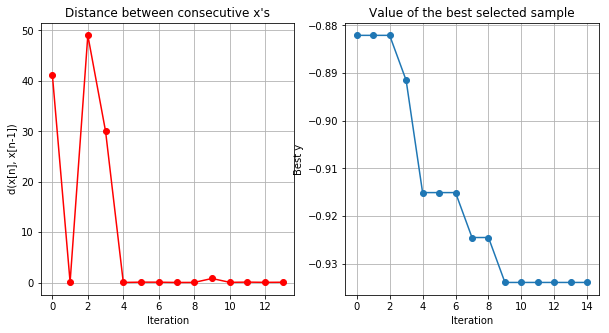

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: se_resnet50, batch_size: 16, epochs: 20
adam_lr: 0.03134003577804291, adam_b1: 0.9257053529683192, adam_b2: 0.9715294653194095, adam_wtdecay: 0.1606630701880286


Training stopped early at 12 epochs.
Training completed in 4m 26s
Best validation accuracy: 0.6840
Associated train accuracy: 0.6852
Associated train loss: 0.7833

ITERATION 2
model: se_resnet50, batch_size: 64, epochs: 10
adam_lr: 0.012810275522489499, adam_b1: 0.8483672906709249, adam_b2: 0.960700105723644, adam_wtdecay: 0.2714938855271771


Training stopped early at 10 epochs.
Training completed in 3m 41s
Best validation accuracy: 0.7500
Associated train accuracy: 0.7460
Associated train loss: 0.6613

ITERATION 3
model: se_resnet50, batch_size: 16, epochs: 30
adam_lr: 0.09215406669592614, adam_b1: 0.8829699480907108, adam_b2: 0.97694401833676, adam_wtdecay: 0.30428581357227924


Training stopped early at 10 epochs.
Training completed in 3m 42s
Best validation accuracy: 0.6698
Associated train accuracy: 0.6630
Associated train loss: 0.8062

ITERATION 4
model: se_resnet50, batch_size: 24, epochs: 10
adam_lr: 0.07196810837398945, adam_b1: 0.8901245558428804, adam_b2: 0.9574685840384451, adam_wtdecay: 0.4166674905832167


Training completed in 3m 42s
Best validation accuracy: 0.6651
Associated train accuracy: 0.7136
Associated train loss: 0.6969

ITERATION 5
model: se_resnet50, batch_size: 32, epochs: 20
adam_lr: 0.050892744131914185, adam_b1: 0.9140274773369648, adam_b2: 0.9552245769446481, adam_wtdecay: 0.12014617182415632


Training stopped early at 13 epochs.
Training completed in 4m 49s
Best validation accuracy: 0.6415
Associated train accuracy: 0.6589
Associated train loss: 0.8551

ITERATION 6
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 1.0


Training completed in 7m 25s
Best validation accuracy: 0.7594
Associated train accuracy: 0.7611
Associated train loss: 0.6592

ITERATION 7
model: se_resnet50, batch_size: 64, epochs: 30
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.95, adam_wtdecay: 0.0


Training stopped early at 6 epochs.
Training completed in 2m 13s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5658
Associated train loss: 1.1795

ITERATION 8
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.06361209332887433, adam_b1: 0.8845873128508754, adam_b2: 0.972737161805271, adam_wtdecay: 0.9177133733658958


Training stopped early at 20 epochs.
Training completed in 7m 22s
Best validation accuracy: 0.7594
Associated train accuracy: 0.7955
Associated train loss: 0.5065

ITERATION 9
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.08257640506154587, adam_b1: 0.9061686121495848, adam_b2: 0.9589409652847748, adam_wtdecay: 0.9125257304632051


Training stopped early at 15 epochs.
Training completed in 5m 32s
Best validation accuracy: 0.6981
Associated train accuracy: 0.7470
Associated train loss: 0.6726

ITERATION 10
model: se_resnet50, batch_size: 64, epochs: 10
adam_lr: 0.012792804877507894, adam_b1: 0.848341356852886, adam_b2: 0.9607198874179977, adam_wtdecay: 0.27180448213265723


Training stopped early at 7 epochs.
Training completed in 2m 36s
Best validation accuracy: 0.6934
Associated train accuracy: 0.6872
Associated train loss: 0.7770

ITERATION 11
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 1.0


Training completed in 7m 25s
Best validation accuracy: 0.7264
Associated train accuracy: 0.7621
Associated train loss: 0.6367

ITERATION 12
model: se_resnet50, batch_size: 64, epochs: 20
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 1.0


Training stopped early at 15 epochs.
Training completed in 5m 32s
Best validation accuracy: 0.6981
Associated train accuracy: 0.7217
Associated train loss: 0.7535


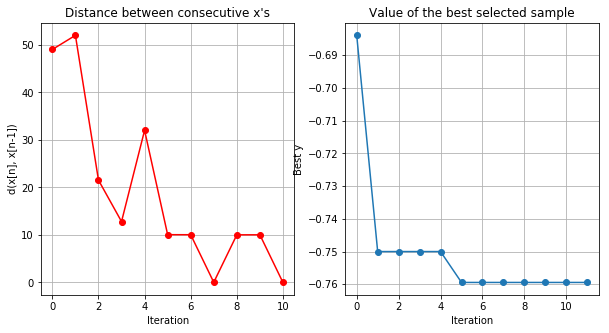

0

0

0

DATA/DIE_VS_ALL_11

ITERATION 1
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.0011478904239854884, adam_b1: 0.807488746923899, adam_b2: 0.9669524564050281, adam_wtdecay: 0.9588098824225273


Training completed in 6m 10s
Best validation accuracy: 0.8679
Associated train accuracy: 0.8634
Associated train loss: 0.3018

ITERATION 2
model: se_resnet101, batch_size: 64, epochs: 30
adam_lr: 0.0964835685916092, adam_b1: 0.8406568916243178, adam_b2: 0.9910084372333914, adam_wtdecay: 0.4008924262803629


Training stopped early at 12 epochs.
Training completed in 7m 24s
Best validation accuracy: 0.7972
Associated train accuracy: 0.8117
Associated train loss: 0.4224

ITERATION 3
model: se_resnet101, batch_size: 16, epochs: 20
adam_lr: 0.06834198059902405, adam_b1: 0.9029222039788186, adam_b2: 0.9677066299336771, adam_wtdecay: 0.14022506106233468


Training stopped early at 11 epochs.
Training completed in 6m 48s
Best validation accuracy: 0.8443
Associated train accuracy: 0.7642
Associated train loss: 0.4971

ITERATION 4
model: se_resnet101, batch_size: 48, epochs: 20
adam_lr: 0.05070622688977613, adam_b1: 0.9292091308346884, adam_b2: 0.9522257958917144, adam_wtdecay: 0.04645452311742282


Training stopped early at 13 epochs.
Training completed in 8m 2s
Best validation accuracy: 0.8066
Associated train accuracy: 0.7773
Associated train loss: 0.4817

ITERATION 5
model: se_resnet101, batch_size: 24, epochs: 40
adam_lr: 0.07536944086839517, adam_b1: 0.8475831507630359, adam_b2: 0.9665087284736231, adam_wtdecay: 0.7461036509205962


Training stopped early at 9 epochs.
Training completed in 5m 34s
Best validation accuracy: 0.8491
Associated train accuracy: 0.8289
Associated train loss: 0.3958

ITERATION 6
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.027662688094614824, adam_b1: 0.9621923818671718, adam_b2: 0.9632016939235427, adam_wtdecay: 0.3713567121253793


Training stopped early at 9 epochs.
Training completed in 5m 34s
Best validation accuracy: 0.8443
Associated train accuracy: 0.8421
Associated train loss: 0.3454

ITERATION 7
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9729241006011393, adam_wtdecay: 1.0


Training completed in 6m 11s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8664
Associated train loss: 0.3288

ITERATION 8
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9925889214137212, adam_wtdecay: 1.0


Training completed in 6m 11s
Best validation accuracy: 0.8726
Associated train accuracy: 0.8482
Associated train loss: 0.3408

ITERATION 9
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9598618809533873, adam_wtdecay: 1.0


Training stopped early at 9 epochs.
Training completed in 5m 34s
Best validation accuracy: 0.8774
Associated train accuracy: 0.8310
Associated train loss: 0.3676

ITERATION 10
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 1.0


Training completed in 6m 11s
Best validation accuracy: 0.8868
Associated train accuracy: 0.8462
Associated train loss: 0.3452

ITERATION 11
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.1, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 1.0


Training completed in 6m 10s
Best validation accuracy: 0.8585
Associated train accuracy: 0.8593
Associated train loss: 0.3333

ITERATION 12
model: se_resnet101, batch_size: 32, epochs: 10
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 1.0


Training completed in 6m 11s
Best validation accuracy: 0.8915
Associated train accuracy: 0.8674
Associated train loss: 0.3081

ITERATION 13
model: se_resnet101, batch_size: 32, epochs: 20
adam_lr: 0.029122549239746786, adam_b1: 0.9289208857212068, adam_b2: 0.9748711428004773, adam_wtdecay: 0.5753297890641187


Training stopped early at 10 epochs.
Training completed in 6m 10s
Best validation accuracy: 0.9009
Associated train accuracy: 0.8765
Associated train loss: 0.3011

ITERATION 14
model: se_resnet101, batch_size: 32, epochs: 20
adam_lr: 0.05176515791530253, adam_b1: 0.9567578339911735, adam_b2: 0.9854176353967465, adam_wtdecay: 0.5139072115956059


Training stopped early at 10 epochs.
Training completed in 6m 11s
Best validation accuracy: 0.8349
Associated train accuracy: 0.8279
Associated train loss: 0.3936

ITERATION 15
model: se_resnet101, batch_size: 32, epochs: 20
adam_lr: 0.02506737257496753, adam_b1: 0.9239354591729669, adam_b2: 0.9729823266194697, adam_wtdecay: 0.5863303354948975


Training stopped early at 7 epochs.
Training completed in 4m 19s
Best validation accuracy: 0.8821
Associated train accuracy: 0.8097
Associated train loss: 0.4362


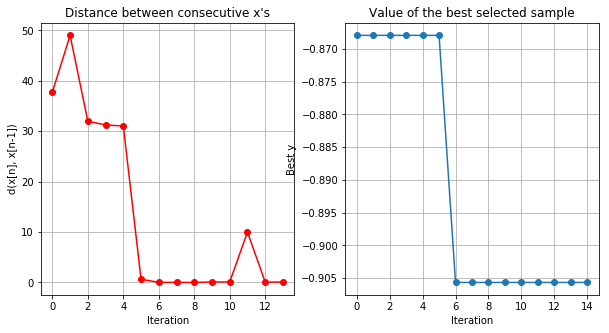

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: se_resnet101, batch_size: 24, epochs: 30
adam_lr: 0.0728657070099844, adam_b1: 0.8915283063256044, adam_b2: 0.9549067742585232, adam_wtdecay: 0.5541144174621468


Training stopped early at 12 epochs.
Training completed in 7m 25s
Best validation accuracy: 0.6792
Associated train accuracy: 0.6599
Associated train loss: 0.8163

ITERATION 2
model: se_resnet101, batch_size: 32, epochs: 30
adam_lr: 0.09432816868269862, adam_b1: 0.987791527935207, adam_b2: 0.9751699624246525, adam_wtdecay: 0.5794592883131451


Training stopped early at 18 epochs.
Training completed in 11m 8s
Best validation accuracy: 0.6415
Associated train accuracy: 0.6721
Associated train loss: 0.8133

ITERATION 3
model: se_resnet101, batch_size: 32, epochs: 20
adam_lr: 0.09574379983199348, adam_b1: 0.9676862459552019, adam_b2: 0.9633860549937782, adam_wtdecay: 0.7396317145294993


Training stopped early at 6 epochs.
Training completed in 3m 42s
Best validation accuracy: 0.6368
Associated train accuracy: 0.5729
Associated train loss: 1.1635

ITERATION 4
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.01810277184583686, adam_b1: 0.8521542551418814, adam_b2: 0.9615621769986998, adam_wtdecay: 0.5136950157141051


Training stopped early at 16 epochs.
Training completed in 9m 54s
Best validation accuracy: 0.7500
Associated train accuracy: 0.7834
Associated train loss: 0.5326

ITERATION 5
model: se_resnet101, batch_size: 64, epochs: 20
adam_lr: 0.07655101815020561, adam_b1: 0.9139984110341827, adam_b2: 0.9965116589822453, adam_wtdecay: 0.5014723259184499


Training stopped early at 14 epochs.
Training completed in 8m 39s
Best validation accuracy: 0.6981
Associated train accuracy: 0.7105
Associated train loss: 0.7086

ITERATION 6
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.08585212374700091, adam_b1: 0.9366122160530047, adam_b2: 0.9721538136815646, adam_wtdecay: 0.9957402187684151


Training stopped early at 16 epochs.
Training completed in 9m 54s
Best validation accuracy: 0.7028
Associated train accuracy: 0.7227
Associated train loss: 0.7596

ITERATION 7
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.04974318073273282, adam_b1: 0.9222528826881969, adam_b2: 0.9755814229961037, adam_wtdecay: 0.3235170876643622


Training stopped early at 17 epochs.
Training completed in 10m 31s
Best validation accuracy: 0.7075
Associated train accuracy: 0.7227
Associated train loss: 0.6879

ITERATION 8
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 0.0


Training stopped early at 6 epochs.
Training completed in 3m 41s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5658
Associated train loss: 1.3353

ITERATION 9
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.06255556227334333, adam_b1: 0.9427077849496668, adam_b2: 0.9788535829698799, adam_wtdecay: 0.5469411919034773


Training stopped early at 12 epochs.
Training completed in 7m 25s
Best validation accuracy: 0.6934
Associated train accuracy: 0.7085
Associated train loss: 0.7409

ITERATION 10
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.008232432357585329, adam_b1: 0.832705111906079, adam_b2: 0.9579196525799388, adam_wtdecay: 0.4898043602315808


Training stopped early at 8 epochs.
Training completed in 4m 57s
Best validation accuracy: 0.7500
Associated train accuracy: 0.7379
Associated train loss: 0.6974

ITERATION 11
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 0.5615658518360889


Training stopped early at 18 epochs.
Training completed in 11m 8s
Best validation accuracy: 0.7736
Associated train accuracy: 0.8016
Associated train loss: 0.5143

ITERATION 12
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 0.6681545190143229


Training stopped early at 16 epochs.
Training completed in 9m 54s
Best validation accuracy: 0.7642
Associated train accuracy: 0.7723
Associated train loss: 0.5955

ITERATION 13
model: se_resnet101, batch_size: 16, epochs: 30
adam_lr: 0.010160440339099117, adam_b1: 0.8508390473521176, adam_b2: 0.9739853150100248, adam_wtdecay: 0.14615800998637973


Training stopped early at 10 epochs.
Training completed in 6m 11s
Best validation accuracy: 0.7170
Associated train accuracy: 0.7045
Associated train loss: 0.6933

ITERATION 14
model: se_resnet101, batch_size: 16, epochs: 30
adam_lr: 0.05355196324777384, adam_b1: 0.8808328977332714, adam_b2: 0.9565724401033294, adam_wtdecay: 0.5087357664466983


Training stopped early at 17 epochs.
Training completed in 10m 32s
Best validation accuracy: 0.7123
Associated train accuracy: 0.7561
Associated train loss: 0.6258

ITERATION 15
model: se_resnet101, batch_size: 48, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 0.590926041117976


Training stopped early at 8 epochs.
Training completed in 4m 57s
Best validation accuracy: 0.6509
Associated train accuracy: 0.5810
Associated train loss: 0.9199


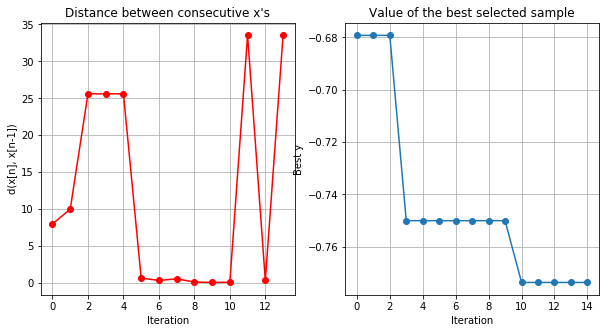

0

0

0

DATA/DIE_VS_ALL_11

ITERATION 1
model: inceptionresnetv2, batch_size: 24, epochs: 40
adam_lr: 0.05119690290268496, adam_b1: 0.8760400093949886, adam_b2: 0.9501448574636374, adam_wtdecay: 0.8805537412313693


Training stopped early at 8 epochs.
Training completed in 7m 5s
Best validation accuracy: 0.9104
Associated train accuracy: 0.8451
Associated train loss: 0.3676

ITERATION 2
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.0530442968849185, adam_b1: 0.9410972231865821, adam_b2: 0.9705097310946302, adam_wtdecay: 0.451958884181649


Training stopped early at 9 epochs.
Training completed in 7m 57s
Best validation accuracy: 0.9245
Associated train accuracy: 0.8289
Associated train loss: 0.3755

ITERATION 3
model: inceptionresnetv2, batch_size: 32, epochs: 40
adam_lr: 0.09990361609994171, adam_b1: 0.9850237805202123, adam_b2: 0.996037972329819, adam_wtdecay: 0.8272845239924828


Training stopped early at 14 epochs.
Training completed in 12m 24s
Best validation accuracy: 0.8962
Associated train accuracy: 0.8836
Associated train loss: 0.2883

ITERATION 4
model: inceptionresnetv2, batch_size: 24, epochs: 10
adam_lr: 0.03457570096354684, adam_b1: 0.8917447329191283, adam_b2: 0.9899510780717672, adam_wtdecay: 0.15227559406320368


Training stopped early at 9 epochs.
Training completed in 7m 58s
Best validation accuracy: 0.8774
Associated train accuracy: 0.8522
Associated train loss: 0.3540

ITERATION 5
model: inceptionresnetv2, batch_size: 64, epochs: 20
adam_lr: 0.06729723809090102, adam_b1: 0.9822186091193483, adam_b2: 0.980119702398021, adam_wtdecay: 0.18067368804205486


Training stopped early at 16 epochs.
Training completed in 14m 9s
Best validation accuracy: 0.8868
Associated train accuracy: 0.8482
Associated train loss: 0.3545

ITERATION 6
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.04797915914970079, adam_b1: 0.8942704237380239, adam_b2: 0.9660404859752961, adam_wtdecay: 0.7629140131917258


Training completed in 8m 53s
Best validation accuracy: 0.8962
Associated train accuracy: 0.8684
Associated train loss: 0.2978

ITERATION 7
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.05028113217845894, adam_b1: 0.9444638540447918, adam_b2: 0.9702230217513361, adam_wtdecay: 0.4489889165298878


Training stopped early at 7 epochs.
Training completed in 6m 11s
Best validation accuracy: 0.9151
Associated train accuracy: 0.8097
Associated train loss: 0.4514

ITERATION 8
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.05576267456000716, adam_b1: 0.9377850202324866, adam_b2: 0.970791722993605, adam_wtdecay: 0.45488094880497704


Training stopped early at 9 epochs.
Training completed in 7m 57s
Best validation accuracy: 0.8915
Associated train accuracy: 0.8249
Associated train loss: 0.4406

ITERATION 9
model: inceptionresnetv2, batch_size: 24, epochs: 40
adam_lr: 0.05111434038011615, adam_b1: 0.8783982487946284, adam_b2: 0.9523528949229584, adam_wtdecay: 0.878305193284238


Training stopped early at 11 epochs.
Training completed in 9m 45s
Best validation accuracy: 0.9009
Associated train accuracy: 0.8877
Associated train loss: 0.2750

ITERATION 10
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.024321301763487874, adam_b1: 0.8483852551176914, adam_b2: 0.9507901705482772, adam_wtdecay: 0.7423776307053896


Training completed in 8m 52s
Best validation accuracy: 0.9245
Associated train accuracy: 0.8785
Associated train loss: 0.2826

ITERATION 11
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.03301374188045651, adam_b1: 0.8944764847711774, adam_b2: 0.958241212355089, adam_wtdecay: 0.5598553464387548


Training stopped early at 7 epochs.
Training completed in 6m 11s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8340
Associated train loss: 0.3773

ITERATION 12
model: inceptionresnetv2, batch_size: 32, epochs: 10
adam_lr: 0.03133641211105683, adam_b1: 0.8920041285526202, adam_b2: 0.9573490395704585, adam_wtdecay: 0.5584038933216652


Training stopped early at 7 epochs.
Training completed in 6m 11s
Best validation accuracy: 0.8726
Associated train accuracy: 0.8320
Associated train loss: 0.3991

ITERATION 13
model: inceptionresnetv2, batch_size: 48, epochs: 40
adam_lr: 0.06014587311289612, adam_b1: 0.851982862432135, adam_b2: 0.9813764878076904, adam_wtdecay: 0.47131707623581


Training stopped early at 15 epochs.
Training completed in 13m 17s
Best validation accuracy: 0.8962
Associated train accuracy: 0.8279
Associated train loss: 0.4388

ITERATION 14
model: inceptionresnetv2, batch_size: 24, epochs: 20
adam_lr: 0.0038719007237404623, adam_b1: 0.8160758620237317, adam_b2: 0.9958570318298734, adam_wtdecay: 0.8704875920505629


Training stopped early at 6 epochs.
Training completed in 5m 18s
Best validation accuracy: 0.8915
Associated train accuracy: 0.7500
Associated train loss: 0.5229

ITERATION 15
model: inceptionresnetv2, batch_size: 24, epochs: 30
adam_lr: 0.06512722272910529, adam_b1: 0.8584899601736203, adam_b2: 0.9507147138261073, adam_wtdecay: 0.6929541816171834


Training stopped early at 18 epochs.
Training completed in 15m 55s
Best validation accuracy: 0.8868
Associated train accuracy: 0.8937
Associated train loss: 0.2821


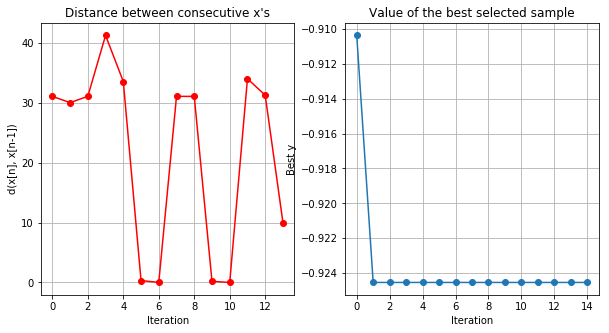

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: inceptionresnetv2, batch_size: 16, epochs: 40
adam_lr: 0.0249294188829282, adam_b1: 0.9674968250553616, adam_b2: 0.9534218205789066, adam_wtdecay: 0.18646025076029382


Training stopped early at 14 epochs.
Training completed in 12m 25s
Best validation accuracy: 0.7075
Associated train accuracy: 0.7591
Associated train loss: 0.6286

ITERATION 2
model: inceptionresnetv2, batch_size: 32, epochs: 20
adam_lr: 0.08901977167493777, adam_b1: 0.8338036374207654, adam_b2: 0.9695351284244209, adam_wtdecay: 0.4400741120674446


Training stopped early at 11 epochs.
Training completed in 9m 44s
Best validation accuracy: 0.7358
Associated train accuracy: 0.7156
Associated train loss: 0.7159

ITERATION 3
model: inceptionresnetv2, batch_size: 24, epochs: 30
adam_lr: 0.06348116327578644, adam_b1: 0.8946745853871428, adam_b2: 0.9674105348070742, adam_wtdecay: 0.808285062809854


Training stopped early at 9 epochs.
Training completed in 7m 59s
Best validation accuracy: 0.7736
Associated train accuracy: 0.7065
Associated train loss: 0.7349

ITERATION 4
model: inceptionresnetv2, batch_size: 24, epochs: 20
adam_lr: 0.022813876031660258, adam_b1: 0.8835939675026405, adam_b2: 0.9852625147250562, adam_wtdecay: 0.8291464058620052


Training stopped early at 14 epochs.
Training completed in 12m 25s
Best validation accuracy: 0.7689
Associated train accuracy: 0.8057
Associated train loss: 0.5016

ITERATION 5
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.004663923665542391, adam_b1: 0.9679910256911377, adam_b2: 0.9636266652690124, adam_wtdecay: 0.5883259282146668


Training completed in 26m 37s
Best validation accuracy: 0.8349
Associated train accuracy: 0.8381
Associated train loss: 0.4152

ITERATION 6
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.019186705516050475, adam_b1: 0.8111847696840773, adam_b2: 0.9510984217438094, adam_wtdecay: 0.7462416394688


Training stopped early at 10 epochs.
Training completed in 8m 51s
Best validation accuracy: 0.7547
Associated train accuracy: 0.7662
Associated train loss: 0.6330

ITERATION 7
model: inceptionresnetv2, batch_size: 24, epochs: 30
adam_lr: 0.06328793204618016, adam_b1: 0.904827369082985, adam_b2: 0.9742066718693887, adam_wtdecay: 0.7865833860184317


Training stopped early at 17 epochs.
Training completed in 15m 3s
Best validation accuracy: 0.7877
Associated train accuracy: 0.7854
Associated train loss: 0.5474

ITERATION 8
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.0017032167672457034, adam_b1: 0.99, adam_b2: 0.9661652446962389, adam_wtdecay: 0.5561327548863267


Training stopped early at 11 epochs.
Training completed in 9m 46s
Best validation accuracy: 0.7311
Associated train accuracy: 0.7186
Associated train loss: 0.7450

ITERATION 9
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.005019395210870736, adam_b1: 0.9654877833229243, adam_b2: 0.9633386050827943, adam_wtdecay: 0.5920225532456626


Training stopped early at 24 epochs.
Training completed in 21m 17s
Best validation accuracy: 0.7925
Associated train accuracy: 0.8047
Associated train loss: 0.4823

ITERATION 10
model: inceptionresnetv2, batch_size: 24, epochs: 30
adam_lr: 0.06334690089552088, adam_b1: 0.9017292597850757, adam_b2: 0.972132837129224, adam_wtdecay: 0.7932056342493438


Training stopped early at 9 epochs.
Training completed in 7m 58s
Best validation accuracy: 0.7547
Associated train accuracy: 0.7449
Associated train loss: 0.6881

ITERATION 11
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.0037729794089585234, adam_b1: 0.9688114239778054, adam_b2: 0.9624604561759492, adam_wtdecay: 0.5877833233957103


Training stopped early at 10 epochs.
Training completed in 8m 52s
Best validation accuracy: 0.7642
Associated train accuracy: 0.7500
Associated train loss: 0.6749

ITERATION 12
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.06776751677477463, adam_b1: 0.9509384062004875, adam_b2: 0.9687931408979739, adam_wtdecay: 0.6260507327691922


Training stopped early at 14 epochs.
Training completed in 12m 26s
Best validation accuracy: 0.7642
Associated train accuracy: 0.7794
Associated train loss: 0.5953

ITERATION 13
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.03973667882910586, adam_b1: 0.9689890869405293, adam_b2: 0.9858379977298171, adam_wtdecay: 0.6060374393363555


Training stopped early at 11 epochs.
Training completed in 9m 45s
Best validation accuracy: 0.7642
Associated train accuracy: 0.7652
Associated train loss: 0.6199

ITERATION 14
model: inceptionresnetv2, batch_size: 48, epochs: 30
adam_lr: 0.07822501976054543, adam_b1: 0.9322636539781184, adam_b2: 0.9651918303846057, adam_wtdecay: 0.5828945570114952


Training stopped early at 9 epochs.
Training completed in 7m 58s
Best validation accuracy: 0.7311
Associated train accuracy: 0.7034
Associated train loss: 0.7307

ITERATION 15
model: inceptionresnetv2, batch_size: 24, epochs: 30
adam_lr: 0.0644158485658775, adam_b1: 0.9192157442019431, adam_b2: 0.9730212767173319, adam_wtdecay: 0.7534348960696492


Training stopped early at 11 epochs.
Training completed in 9m 45s
Best validation accuracy: 0.7877
Associated train accuracy: 0.7419
Associated train loss: 0.6268


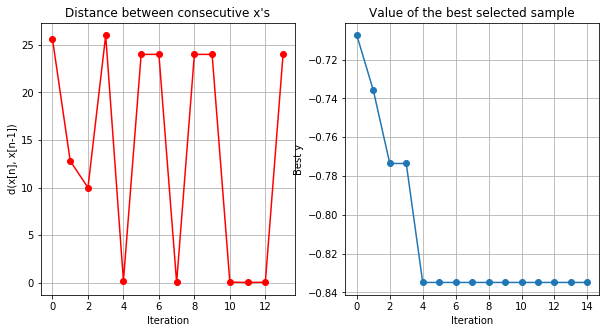

0

0

0

DATA/DIE_VS_ALL_11

ITERATION 1
model: inceptionv4, batch_size: 24, epochs: 10
adam_lr: 0.04295217442839262, adam_b1: 0.9783069282682264, adam_b2: 0.9884163197646163, adam_wtdecay: 0.18897045439890336


Training completed in 6m 48s
Best validation accuracy: 0.6132
Associated train accuracy: 0.5678
Associated train loss: 0.6832

ITERATION 2
model: inceptionv4, batch_size: 64, epochs: 30
adam_lr: 0.07543295023752711, adam_b1: 0.9065199056036012, adam_b2: 0.9926986300286966, adam_wtdecay: 0.5439105247243402


Training stopped early at 7 epochs.
Training completed in 4m 46s
Best validation accuracy: 0.8208
Associated train accuracy: 0.7379
Associated train loss: 0.5553

ITERATION 3
model: inceptionv4, batch_size: 24, epochs: 10
adam_lr: 0.007228393557022989, adam_b1: 0.981031855414426, adam_b2: 0.9599656239336398, adam_wtdecay: 0.6447146736983627


Training stopped early at 10 epochs.
Training completed in 6m 49s
Best validation accuracy: 0.9292
Associated train accuracy: 0.8502
Associated train loss: 0.3805

ITERATION 4
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.09201381010604846, adam_b1: 0.8013176965300637, adam_b2: 0.9697744712159898, adam_wtdecay: 0.6447645067160899


Training stopped early at 8 epochs.
Training completed in 5m 26s
Best validation accuracy: 0.7877
Associated train accuracy: 0.7095
Associated train loss: 0.5596

ITERATION 5
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.08796155604764103, adam_b1: 0.9373370599930796, adam_b2: 0.996693890300428, adam_wtdecay: 0.49613921643542536


Training stopped early at 9 epochs.
Training completed in 6m 8s
Best validation accuracy: 0.8538
Associated train accuracy: 0.7834
Associated train loss: 0.4970

ITERATION 6
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.07011366899789614, adam_b1: 0.920422969182871, adam_b2: 0.9887633032770548, adam_wtdecay: 0.501742509593521


Training stopped early at 19 epochs.
Training completed in 12m 57s
Best validation accuracy: 0.8538
Associated train accuracy: 0.8107
Associated train loss: 0.4243

ITERATION 7
model: inceptionv4, batch_size: 24, epochs: 10
adam_lr: 0.001, adam_b1: 0.9817952489989232, adam_b2: 0.9519948055399416, adam_wtdecay: 0.7723975333249243


Training completed in 6m 49s
Best validation accuracy: 0.8679
Associated train accuracy: 0.8391
Associated train loss: 0.3725

ITERATION 8
model: inceptionv4, batch_size: 24, epochs: 10
adam_lr: 0.001, adam_b1: 0.8661783053751337, adam_b2: 0.9542038200929791, adam_wtdecay: 0.6229940690190373


Training stopped early at 9 epochs.
Training completed in 6m 8s
Best validation accuracy: 0.8538
Associated train accuracy: 0.8350
Associated train loss: 0.3806

ITERATION 9
model: inceptionv4, batch_size: 24, epochs: 10
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 0.6381498676921691


Training stopped early at 6 epochs.
Training completed in 4m 5s
Best validation accuracy: 0.8726
Associated train accuracy: 0.7551
Associated train loss: 0.5879

ITERATION 10
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.06627006184957195, adam_b1: 0.8460566886752743, adam_b2: 0.9756717314838622, adam_wtdecay: 0.18412211894180425


Training stopped early at 8 epochs.
Training completed in 5m 27s
Best validation accuracy: 0.7877
Associated train accuracy: 0.7257
Associated train loss: 0.5648

ITERATION 11
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 0.7684563234738149


Training stopped early at 7 epochs.
Training completed in 4m 46s
Best validation accuracy: 0.8679
Associated train accuracy: 0.8026
Associated train loss: 0.4429

ITERATION 12
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 0.855657629885037


Training stopped early at 18 epochs.
Training completed in 12m 17s
Best validation accuracy: 0.9104
Associated train accuracy: 0.8502
Associated train loss: 0.3459

ITERATION 13
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.1, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 0.989355294572553


Training stopped early at 14 epochs.
Training completed in 9m 32s
Best validation accuracy: 0.8491
Associated train accuracy: 0.7885
Associated train loss: 0.4781

ITERATION 14
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 0.7287043591781217


Training stopped early at 8 epochs.
Training completed in 5m 27s
Best validation accuracy: 0.8066
Associated train accuracy: 0.7328
Associated train loss: 0.5804

ITERATION 15
model: inceptionv4, batch_size: 32, epochs: 40
adam_lr: 0.001, adam_b1: 0.9031597627313194, adam_b2: 0.95, adam_wtdecay: 0.8983477563586729


Training stopped early at 7 epochs.
Training completed in 4m 47s
Best validation accuracy: 0.8821
Associated train accuracy: 0.7986
Associated train loss: 0.4785


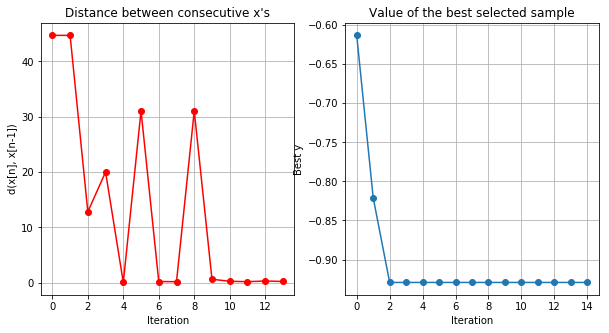

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: inceptionv4, batch_size: 48, epochs: 20
adam_lr: 0.05592162977023996, adam_b1: 0.8952018343145519, adam_b2: 0.9702117805581048, adam_wtdecay: 0.8209366422617229


Training stopped early at 14 epochs.
Training completed in 9m 33s
Best validation accuracy: 0.6604
Associated train accuracy: 0.6518
Associated train loss: 0.8541

ITERATION 2
model: inceptionv4, batch_size: 32, epochs: 10
adam_lr: 0.009328270907887019, adam_b1: 0.9743699639467758, adam_b2: 0.9519629954675246, adam_wtdecay: 0.6759008676316072


Training completed in 6m 49s
Best validation accuracy: 0.7500
Associated train accuracy: 0.7783
Associated train loss: 0.6546

ITERATION 3
model: inceptionv4, batch_size: 16, epochs: 20
adam_lr: 0.03226030100871093, adam_b1: 0.906992395084777, adam_b2: 0.9660569427560388, adam_wtdecay: 0.38729031638982425


Training stopped early at 6 epochs.
Training completed in 4m 5s
Best validation accuracy: 0.6132
Associated train accuracy: 0.5597
Associated train loss: 1.2532

ITERATION 4
model: inceptionv4, batch_size: 32, epochs: 30
adam_lr: 0.014591193857762128, adam_b1: 0.9668930032841059, adam_b2: 0.9643727097560566, adam_wtdecay: 0.7301532473898861


Training stopped early at 8 epochs.
Training completed in 5m 27s
Best validation accuracy: 0.7594
Associated train accuracy: 0.6984
Associated train loss: 0.7805

ITERATION 5
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.014602022887275645, adam_b1: 0.8550195260028388, adam_b2: 0.9595435766267357, adam_wtdecay: 0.7805889101524692


Training stopped early at 8 epochs.
Training completed in 5m 27s
Best validation accuracy: 0.7736
Associated train accuracy: 0.7227
Associated train loss: 0.7866

ITERATION 6
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.1, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 0.0


Training stopped early at 6 epochs.
Training completed in 4m 5s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5506
Associated train loss: 1.3066

ITERATION 7
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.012663137841628808, adam_b1: 0.846689329299346, adam_b2: 0.957669368800945, adam_wtdecay: 0.7644439833205321


Training stopped early at 15 epochs.
Training completed in 10m 14s
Best validation accuracy: 0.7547
Associated train accuracy: 0.7713
Associated train loss: 0.5917

ITERATION 8
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.023605802837741656, adam_b1: 0.8937249109610532, adam_b2: 0.9682491664514197, adam_wtdecay: 0.8556394372548768


Training stopped early at 11 epochs.
Training completed in 7m 30s
Best validation accuracy: 0.7028
Associated train accuracy: 0.6538
Associated train loss: 0.8716

ITERATION 9
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.05380224138219883, adam_b1: 0.8682018789061633, adam_b2: 0.9700817184317335, adam_wtdecay: 0.7833449652122016


Training stopped early at 18 epochs.
Training completed in 12m 16s
Best validation accuracy: 0.6981
Associated train accuracy: 0.6903
Associated train loss: 0.7919

ITERATION 10
model: inceptionv4, batch_size: 32, epochs: 30
adam_lr: 0.037905864340789096, adam_b1: 0.9783645578068982, adam_b2: 0.9669179222050117, adam_wtdecay: 0.7690008714432123


Training stopped early at 8 epochs.
Training completed in 5m 26s
Best validation accuracy: 0.6462
Associated train accuracy: 0.6528
Associated train loss: 0.8603

ITERATION 11
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.001, adam_b1: 0.8482732539576142, adam_b2: 0.9507729580344951, adam_wtdecay: 0.789348882671094


Training stopped early at 15 epochs.
Training completed in 10m 14s
Best validation accuracy: 0.7264
Associated train accuracy: 0.7227
Associated train loss: 0.7325

ITERATION 12
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.01084433647287002, adam_b1: 0.8646820833829485, adam_b2: 0.9703969044581785, adam_wtdecay: 0.7731832640440981


Training stopped early at 12 epochs.
Training completed in 8m 11s
Best validation accuracy: 0.7877
Associated train accuracy: 0.7591
Associated train loss: 0.6642

ITERATION 13
model: inceptionv4, batch_size: 32, epochs: 20
adam_lr: 0.010963303559155101, adam_b1: 0.8789649372438123, adam_b2: 0.9563749690019316, adam_wtdecay: 0.7698138225742115


Training stopped early at 15 epochs.
Training completed in 10m 14s
Best validation accuracy: 0.7783
Associated train accuracy: 0.7581
Associated train loss: 0.6565

ITERATION 14
model: inceptionv4, batch_size: 32, epochs: 30
adam_lr: 0.001, adam_b1: 0.9576835238533804, adam_b2: 0.9623296935862807, adam_wtdecay: 0.6989653073418944


Training stopped early at 15 epochs.
Training completed in 10m 14s
Best validation accuracy: 0.7453
Associated train accuracy: 0.7358
Associated train loss: 0.6992

ITERATION 15
model: inceptionv4, batch_size: 32, epochs: 30
adam_lr: 0.001, adam_b1: 0.9779253374470334, adam_b2: 0.9999, adam_wtdecay: 0.7144638167511966


Training stopped early at 17 epochs.
Training completed in 11m 36s
Best validation accuracy: 0.7123
Associated train accuracy: 0.6761
Associated train loss: 0.8122


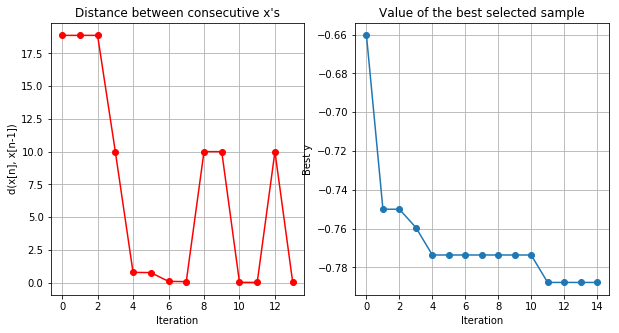

0

0

0

DATA/DIE_VS_ALL_11

ITERATION 1
model: vgg16, batch_size: 32, epochs: 40
adam_lr: 0.05413816443832108, adam_b1: 0.8693025721689481, adam_b2: 0.9511112378027855, adam_wtdecay: 0.31479440975368156


Training stopped early at 7 epochs.
Training completed in 3m 52s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5101
Associated train loss: 1.4542

ITERATION 2
model: vgg16, batch_size: 32, epochs: 10
adam_lr: 0.025235153869259695, adam_b1: 0.905005095553509, adam_b2: 0.9598704774997133, adam_wtdecay: 0.267005329081368


Skipping because maximum recursion depth exceeded
DATA/4_CLASS_11

ITERATION 1
model: vgg16, batch_size: 24, epochs: 10
adam_lr: 0.028847845394353793, adam_b1: 0.925887994549666, adam_b2: 0.9987101042897127, adam_wtdecay: 0.9828519090983053


maximum recursion depth exceeded

ITERATION 2
model: vgg16, batch_size: 24, epochs: 40
adam_lr: 0.023681842684651212, adam_b1: 0.9431097446596344, adam_b2: 0.9769387117710487, adam_wtdecay: 0.47724603650844766


Skipping because maximum recursion depth exceeded
DATA/DIE_VS_ALL_11

ITERATION 1
model: vgg19, batch_size: 48, epochs: 10
adam_lr: 0.07143240924628103, adam_b1: 0.9620815039562638, adam_b2: 0.9551793838706104, adam_wtdecay: 0.5580022272591425


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/alwood/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [23:24<00:00, 409153.09it/s]  


maximum recursion depth exceeded

ITERATION 2
model: vgg19, batch_size: 32, epochs: 40
adam_lr: 0.0765620126450548, adam_b1: 0.9886921414358112, adam_b2: 0.9699567220452883, adam_wtdecay: 0.06124665187412881


Skipping because maximum recursion depth exceeded
DATA/4_CLASS_11

ITERATION 1
model: vgg19, batch_size: 16, epochs: 40
adam_lr: 0.06794008022573989, adam_b1: 0.866682975645059, adam_b2: 0.9849885246588992, adam_wtdecay: 0.7855192087287564


maximum recursion depth exceeded

ITERATION 2
model: vgg19, batch_size: 48, epochs: 20
adam_lr: 0.04970252764021703, adam_b1: 0.81639367248642, adam_b2: 0.9690478184246039, adam_wtdecay: 0.782232052378515


Skipping because maximum recursion depth exceeded
DATA/DIE_VS_ALL_11

ITERATION 1
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.035340930618450984, adam_b1: 0.9676175662937704, adam_b2: 0.970023437588172, adam_wtdecay: 0.5540604661137825


Training stopped early at 18 epochs.
Training completed in 8m 7s
Best validation accuracy: 0.8302
Associated train accuracy: 0.8401
Associated train loss: 0.3779

ITERATION 2
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.06012199605899248, adam_b1: 0.8531095733301151, adam_b2: 0.9950408836249975, adam_wtdecay: 0.10675027968955009


Training stopped early at 16 epochs.
Training completed in 7m 14s
Best validation accuracy: 0.8019
Associated train accuracy: 0.7642
Associated train loss: 0.5229

ITERATION 3
model: resnet101, batch_size: 32, epochs: 20
adam_lr: 0.040051432105208264, adam_b1: 0.9059059547659501, adam_b2: 0.9527653545842585, adam_wtdecay: 0.080366299361747


Training stopped early at 14 epochs.
Training completed in 6m 19s
Best validation accuracy: 0.7783
Associated train accuracy: 0.7895
Associated train loss: 0.4439

ITERATION 4
model: resnet101, batch_size: 64, epochs: 10
adam_lr: 0.08529136616159992, adam_b1: 0.8187399003745438, adam_b2: 0.9545842135567861, adam_wtdecay: 0.6006513403500489


Training completed in 4m 31s
Best validation accuracy: 0.7972
Associated train accuracy: 0.7773
Associated train loss: 0.4913

ITERATION 5
model: resnet101, batch_size: 16, epochs: 30
adam_lr: 0.02839325639396616, adam_b1: 0.9779487553302613, adam_b2: 0.9662489724156862, adam_wtdecay: 0.2825345187096371


Training stopped early at 15 epochs.
Training completed in 6m 46s
Best validation accuracy: 0.8066
Associated train accuracy: 0.8300
Associated train loss: 0.4002

ITERATION 6
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.0343562440801246, adam_b1: 0.9693630126681544, adam_b2: 0.968219299185406, adam_wtdecay: 0.5532503277359677


Training stopped early at 19 epochs.
Training completed in 8m 35s
Best validation accuracy: 0.8585
Associated train accuracy: 0.8340
Associated train loss: 0.3650

ITERATION 7
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.03403670833846595, adam_b1: 0.9694739532350183, adam_b2: 0.966928825353751, adam_wtdecay: 0.5532382756396249


Training stopped early at 11 epochs.
Training completed in 4m 58s
Best validation accuracy: 0.7925
Associated train accuracy: 0.8128
Associated train loss: 0.4366

ITERATION 8
model: resnet101, batch_size: 16, epochs: 30
adam_lr: 0.005982215519903287, adam_b1: 0.9674944806069221, adam_b2: 0.9692508910902096, adam_wtdecay: 0.815601822710211


Training stopped early at 10 epochs.
Training completed in 4m 32s
Best validation accuracy: 0.8868
Associated train accuracy: 0.8350
Associated train loss: 0.4006

ITERATION 9
model: resnet101, batch_size: 24, epochs: 20
adam_lr: 0.02420645399889232, adam_b1: 0.8455746984873235, adam_b2: 0.9985655826610739, adam_wtdecay: 0.693474529613687


Training stopped early at 9 epochs.
Training completed in 4m 4s
Best validation accuracy: 0.8491
Associated train accuracy: 0.8279
Associated train loss: 0.4337

ITERATION 10
model: resnet101, batch_size: 64, epochs: 40
adam_lr: 0.0026712112246805534, adam_b1: 0.913549896514472, adam_b2: 0.9851624761298505, adam_wtdecay: 0.21005772981385074


Training stopped early at 9 epochs.
Training completed in 4m 4s
Best validation accuracy: 0.9009
Associated train accuracy: 0.8350
Associated train loss: 0.4122

ITERATION 11
model: resnet101, batch_size: 48, epochs: 10
adam_lr: 0.021406538329427557, adam_b1: 0.9362870530039223, adam_b2: 0.962289345000443, adam_wtdecay: 0.648655737651364


Training completed in 4m 31s
Best validation accuracy: 0.8585
Associated train accuracy: 0.8482
Associated train loss: 0.3591

ITERATION 12
model: resnet101, batch_size: 48, epochs: 40
adam_lr: 0.03954663803222476, adam_b1: 0.8179999566084836, adam_b2: 0.9639951147228843, adam_wtdecay: 0.056892024824864884


Training stopped early at 15 epochs.
Training completed in 6m 47s
Best validation accuracy: 0.8113
Associated train accuracy: 0.7905
Associated train loss: 0.4742

ITERATION 13
model: resnet101, batch_size: 48, epochs: 20
adam_lr: 0.030695977408199234, adam_b1: 0.8153707608147795, adam_b2: 0.9703938372456115, adam_wtdecay: 0.646860276780844


Training stopped early at 16 epochs.
Training completed in 7m 14s
Best validation accuracy: 0.8160
Associated train accuracy: 0.7996
Associated train loss: 0.4279

ITERATION 14
model: resnet101, batch_size: 32, epochs: 30
adam_lr: 0.03665530652838679, adam_b1: 0.8695834825291417, adam_b2: 0.9747025359787759, adam_wtdecay: 0.9437139924367148


Training stopped early at 19 epochs.
Training completed in 8m 35s
Best validation accuracy: 0.8821
Associated train accuracy: 0.8755
Associated train loss: 0.3135

ITERATION 15
model: resnet101, batch_size: 16, epochs: 20
adam_lr: 0.09811454588498503, adam_b1: 0.89908474391514, adam_b2: 0.9710221128378236, adam_wtdecay: 0.3169661506247733


Training stopped early at 12 epochs.
Training completed in 5m 25s
Best validation accuracy: 0.7830
Associated train accuracy: 0.7611
Associated train loss: 0.5032


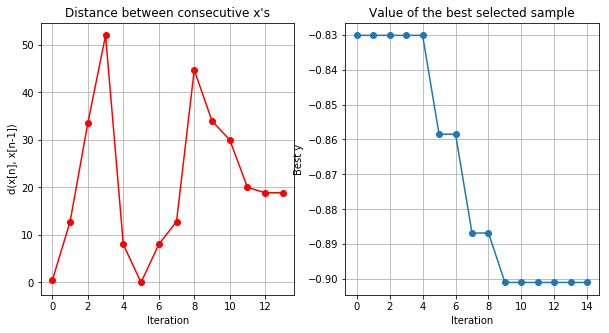

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.02200610801541752, adam_b1: 0.9845489247630352, adam_b2: 0.9932108489696643, adam_wtdecay: 0.3371233506410889


Training stopped early at 11 epochs.
Training completed in 4m 58s
Best validation accuracy: 0.6651
Associated train accuracy: 0.6549
Associated train loss: 0.8770

ITERATION 2
model: resnet101, batch_size: 32, epochs: 40
adam_lr: 0.026940402941227085, adam_b1: 0.8828275801414234, adam_b2: 0.9727550446721341, adam_wtdecay: 0.48030240782919575


Training stopped early at 8 epochs.
Training completed in 3m 37s
Best validation accuracy: 0.5991
Associated train accuracy: 0.6184
Associated train loss: 0.9683

ITERATION 3
model: resnet101, batch_size: 24, epochs: 40
adam_lr: 0.07578979768381582, adam_b1: 0.8813304608511295, adam_b2: 0.9732855079965443, adam_wtdecay: 0.5521681229008819


Training stopped early at 16 epochs.
Training completed in 7m 14s
Best validation accuracy: 0.6321
Associated train accuracy: 0.6255
Associated train loss: 0.9249

ITERATION 4
model: resnet101, batch_size: 16, epochs: 40
adam_lr: 0.0971328678613633, adam_b1: 0.8957795514385078, adam_b2: 0.9951665604997355, adam_wtdecay: 0.42909665513658646


Training stopped early at 7 epochs.
Training completed in 3m 9s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5314
Associated train loss: 1.2828

ITERATION 5
model: resnet101, batch_size: 24, epochs: 40
adam_lr: 0.035996120833856136, adam_b1: 0.900721459932978, adam_b2: 0.9834113873148431, adam_wtdecay: 0.3425492752688689


Training stopped early at 10 epochs.
Training completed in 4m 31s
Best validation accuracy: 0.6226
Associated train accuracy: 0.6468
Associated train loss: 0.9077

ITERATION 6
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.0806638439329089, adam_b1: 0.9309792903455527, adam_b2: 0.9875356277951551, adam_wtdecay: 0.979644118890906


Training stopped early at 16 epochs.
Training completed in 7m 14s
Best validation accuracy: 0.6509
Associated train accuracy: 0.6549
Associated train loss: 0.8856

ITERATION 7
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.001, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 0.0


Training stopped early at 6 epochs.
Training completed in 2m 41s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5162
Associated train loss: 1.2445

ITERATION 8
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.022009588440568273, adam_b1: 0.984544975026072, adam_b2: 0.9932093063446223, adam_wtdecay: 0.33718412321908864


Training stopped early at 12 epochs.
Training completed in 5m 25s
Best validation accuracy: 0.6415
Associated train accuracy: 0.6549
Associated train loss: 0.8678

ITERATION 9
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.021209953775839042, adam_b1: 0.9859764431286673, adam_b2: 0.993638264526538, adam_wtdecay: 0.322742061328839


Training stopped early at 8 epochs.
Training completed in 3m 37s
Best validation accuracy: 0.6132
Associated train accuracy: 0.6073
Associated train loss: 1.0719

ITERATION 10
model: resnet101, batch_size: 24, epochs: 10
adam_lr: 0.03023609742518207, adam_b1: 0.878787043568709, adam_b2: 0.9893832225010742, adam_wtdecay: 0.39663607461874273


Training completed in 4m 31s
Best validation accuracy: 0.6462
Associated train accuracy: 0.6630
Associated train loss: 0.8273

ITERATION 11
model: resnet101, batch_size: 16, epochs: 30
adam_lr: 0.029425116508911504, adam_b1: 0.806268915936348, adam_b2: 0.9626627077578533, adam_wtdecay: 0.06970573984266148


Training stopped early at 18 epochs.
Training completed in 8m 8s
Best validation accuracy: 0.6368
Associated train accuracy: 0.6711
Associated train loss: 0.8497

ITERATION 12
model: resnet101, batch_size: 24, epochs: 30
adam_lr: 0.03870574954533957, adam_b1: 0.9362372831654139, adam_b2: 0.9744152253827033, adam_wtdecay: 0.6795326110369195


Training stopped early at 10 epochs.
Training completed in 4m 31s
Best validation accuracy: 0.6557
Associated train accuracy: 0.6457
Associated train loss: 0.8919

ITERATION 13
model: resnet101, batch_size: 48, epochs: 10
adam_lr: 0.06153997445366958, adam_b1: 0.8592112734804817, adam_b2: 0.9886359571738756, adam_wtdecay: 0.3905753865348697


Training completed in 4m 31s
Best validation accuracy: 0.6038
Associated train accuracy: 0.6134
Associated train loss: 0.9586

ITERATION 14
model: resnet101, batch_size: 32, epochs: 40
adam_lr: 0.06918287133697383, adam_b1: 0.8235463646306508, adam_b2: 0.957989500490373, adam_wtdecay: 0.130669790403527


Training stopped early at 7 epochs.
Training completed in 3m 9s
Best validation accuracy: 0.5849
Associated train accuracy: 0.5668
Associated train loss: 1.1656

ITERATION 15
model: resnet101, batch_size: 64, epochs: 20
adam_lr: 0.0809030299068771, adam_b1: 0.916948820127125, adam_b2: 0.9951154589848472, adam_wtdecay: 0.05987786855417032


Training stopped early at 7 epochs.
Training completed in 3m 9s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5668
Associated train loss: 1.1602


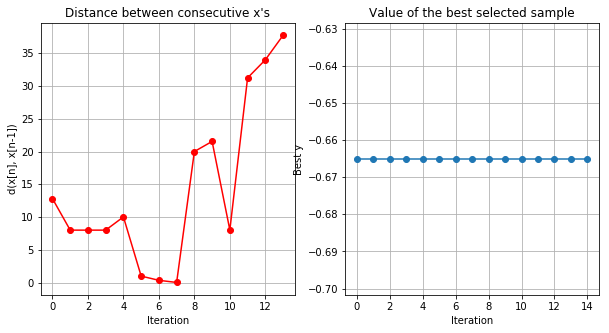

0

0

0

DATA/DIE_VS_ALL_11

ITERATION 1
model: senet154, batch_size: 32, epochs: 30
adam_lr: 0.042612265509405625, adam_b1: 0.8831312376007808, adam_b2: 0.973154859201475, adam_wtdecay: 0.8165562787177607


Training stopped early at 10 epochs.
Training completed in 23m 3s
Best validation accuracy: 0.8915
Associated train accuracy: 0.9008
Associated train loss: 0.2684

ITERATION 2
model: senet154, batch_size: 32, epochs: 30
adam_lr: 0.06719707599717342, adam_b1: 0.8208254052562843, adam_b2: 0.9965658021945144, adam_wtdecay: 0.05576654725561758


Training stopped early at 23 epochs.
Training completed in 53m 3s
Best validation accuracy: 0.8632
Associated train accuracy: 0.8219
Associated train loss: 0.4039

ITERATION 3
model: senet154, batch_size: 24, epochs: 10
adam_lr: 0.022868343030307905, adam_b1: 0.9174948523173065, adam_b2: 0.971374802372443, adam_wtdecay: 0.23872584116006124


Training completed in 23m 4s
Best validation accuracy: 0.8915
Associated train accuracy: 0.8866
Associated train loss: 0.2726

ITERATION 4
model: senet154, batch_size: 32, epochs: 30
adam_lr: 0.08007514198293846, adam_b1: 0.9290063645581547, adam_b2: 0.995874151807696, adam_wtdecay: 0.31411364844329404


Training stopped early at 12 epochs.
Training completed in 27m 41s
Best validation accuracy: 0.8632
Associated train accuracy: 0.8360
Associated train loss: 0.3896

ITERATION 5
model: senet154, batch_size: 16, epochs: 30
adam_lr: 0.04359046829937102, adam_b1: 0.9486373096395895, adam_b2: 0.9527355345796862, adam_wtdecay: 0.12133455211841349


Training stopped early at 18 epochs.
Training completed in 41m 31s
Best validation accuracy: 0.8255
Associated train accuracy: 0.7905
Associated train loss: 0.4597

ITERATION 6
model: senet154, batch_size: 32, epochs: 30
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.95, adam_wtdecay: 1.0


Training stopped early at 12 epochs.
Training completed in 27m 35s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8532
Associated train loss: 0.3331

ITERATION 7
model: senet154, batch_size: 16, epochs: 10
adam_lr: 0.014622539634994075, adam_b1: 0.8889506404596013, adam_b2: 0.9646436643137063, adam_wtdecay: 0.2454566891980582


Training completed in 23m 3s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8826
Associated train loss: 0.2875

ITERATION 8
model: senet154, batch_size: 16, epochs: 10
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 1.0


Training completed in 23m 3s
Best validation accuracy: 0.9151
Associated train accuracy: 0.8907
Associated train loss: 0.2613

ITERATION 9
model: senet154, batch_size: 32, epochs: 10
adam_lr: 0.04158872415282812, adam_b1: 0.884582632332992, adam_b2: 0.9680447708586629, adam_wtdecay: 0.2655604953292896


Training completed in 23m 4s
Best validation accuracy: 0.9009
Associated train accuracy: 0.8482
Associated train loss: 0.3742

ITERATION 10
model: senet154, batch_size: 32, epochs: 20
adam_lr: 0.007408694831047764, adam_b1: 0.9359435746815885, adam_b2: 0.9554470352519345, adam_wtdecay: 0.9682849935557133


Training stopped early at 17 epochs.
Training completed in 39m 11s
Best validation accuracy: 0.9387
Associated train accuracy: 0.9372
Associated train loss: 0.1782

ITERATION 11
model: senet154, batch_size: 32, epochs: 20
adam_lr: 0.0766712115750438, adam_b1: 0.8, adam_b2: 0.9521922457046564, adam_wtdecay: 0.2516230384198813


Training stopped early at 19 epochs.
Training completed in 43m 49s
Best validation accuracy: 0.8349
Associated train accuracy: 0.8016
Associated train loss: 0.4432

ITERATION 12
model: senet154, batch_size: 32, epochs: 20
adam_lr: 0.1, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 1.0


Training stopped early at 12 epochs.
Training completed in 27m 38s
Best validation accuracy: 0.9198
Associated train accuracy: 0.8877
Associated train loss: 0.2648

ITERATION 13
model: senet154, batch_size: 32, epochs: 20
adam_lr: 0.001, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 1.0


Training completed in 46m 8s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8664
Associated train loss: 0.3175

ITERATION 14
model: senet154, batch_size: 32, epochs: 20
adam_lr: 0.001, adam_b1: 0.8397552251199872, adam_b2: 0.95, adam_wtdecay: 1.0


Training stopped early at 15 epochs.
Training completed in 34m 37s
Best validation accuracy: 0.9104
Associated train accuracy: 0.8522
Associated train loss: 0.3200

ITERATION 15
model: senet154, batch_size: 32, epochs: 20
adam_lr: 0.1, adam_b1: 0.9346311161718492, adam_b2: 0.95, adam_wtdecay: 1.0


Training stopped early at 12 epochs.
Training completed in 27m 38s
Best validation accuracy: 0.8585
Associated train accuracy: 0.8117
Associated train loss: 0.4239


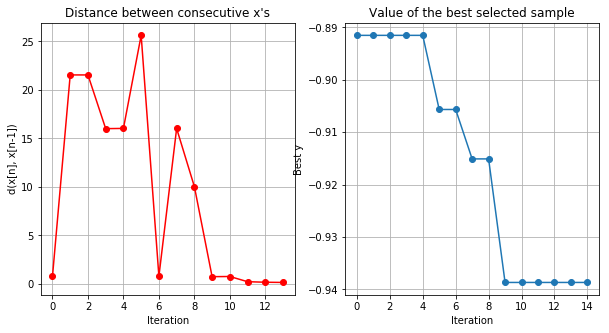

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: senet154, batch_size: 64, epochs: 10
adam_lr: 0.010175212291049292, adam_b1: 0.8983341666133667, adam_b2: 0.9599585675837361, adam_wtdecay: 0.09336680232990613


Training completed in 23m 3s
Best validation accuracy: 0.6840
Associated train accuracy: 0.7277
Associated train loss: 0.6835

ITERATION 2
model: senet154, batch_size: 24, epochs: 30
adam_lr: 0.06889896008374176, adam_b1: 0.8242115776914478, adam_b2: 0.9744249025263858, adam_wtdecay: 0.8065762220587628


Training stopped early at 12 epochs.
Training completed in 27m 36s
Best validation accuracy: 0.7500
Associated train accuracy: 0.7540
Associated train loss: 0.6355

ITERATION 3
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.006484825127102757, adam_b1: 0.821935559613404, adam_b2: 0.9870509775851591, adam_wtdecay: 0.2757040997992951


Training stopped early at 8 epochs.
Training completed in 18m 27s
Best validation accuracy: 0.7783
Associated train accuracy: 0.7591
Associated train loss: 0.6436

ITERATION 4
model: senet154, batch_size: 16, epochs: 10
adam_lr: 0.07648547324227238, adam_b1: 0.8191328312244931, adam_b2: 0.9963444323170697, adam_wtdecay: 0.454171500997679


Training completed in 22m 57s
Best validation accuracy: 0.7358
Associated train accuracy: 0.7105
Associated train loss: 0.7266

ITERATION 5
model: senet154, batch_size: 24, epochs: 30
adam_lr: 0.04519084272508491, adam_b1: 0.8037265567240028, adam_b2: 0.9847966028099092, adam_wtdecay: 0.2717269235667975


Training stopped early at 8 epochs.
Training completed in 18m 18s
Best validation accuracy: 0.6462
Associated train accuracy: 0.6559
Associated train loss: 0.8820

ITERATION 6
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.03597045910453349, adam_b1: 0.8266961591386691, adam_b2: 0.9863608442581743, adam_wtdecay: 0.2735024974460774


Training stopped early at 14 epochs.
Training completed in 32m 9s
Best validation accuracy: 0.7358
Associated train accuracy: 0.7824
Associated train loss: 0.5939

ITERATION 7
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.8068543839227219, adam_b2: 0.9892372237429939, adam_wtdecay: 0.2826785943858816


Training stopped early at 12 epochs.
Training completed in 27m 33s
Best validation accuracy: 0.7783
Associated train accuracy: 0.7743
Associated train loss: 0.5853

ITERATION 8
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.8341129842608951, adam_b2: 0.9887712890528453, adam_wtdecay: 0.30198170718239314


Training stopped early at 17 epochs.
Training completed in 39m 11s
Best validation accuracy: 0.7830
Associated train accuracy: 0.7986
Associated train loss: 0.5048

ITERATION 9
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.8777970733236836, adam_b2: 0.9999, adam_wtdecay: 0.274181793931091


Training stopped early at 29 epochs.
Training completed in 66m 53s
Best validation accuracy: 0.8066
Associated train accuracy: 0.8370
Associated train loss: 0.4483

ITERATION 10
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.9413952567509075, adam_b2: 0.9999, adam_wtdecay: 0.2488696733906589


Training stopped early at 22 epochs.
Training completed in 50m 48s
Best validation accuracy: 0.8019
Associated train accuracy: 0.8168
Associated train loss: 0.4986

ITERATION 11
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.8906532613851593, adam_b2: 0.9999, adam_wtdecay: 0.17704240385380646


Training stopped early at 24 epochs.
Training completed in 55m 23s
Best validation accuracy: 0.7972
Associated train accuracy: 0.8128
Associated train loss: 0.4692

ITERATION 12
model: senet154, batch_size: 24, epochs: 20
adam_lr: 0.04288559570228402, adam_b1: 0.8555517383182444, adam_b2: 0.9882918982795994, adam_wtdecay: 0.6774852412835175


Training stopped early at 15 epochs.
Training completed in 34m 37s
Best validation accuracy: 0.7783
Associated train accuracy: 0.8016
Associated train loss: 0.5047

ITERATION 13
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 0.37414798833694624


Training stopped early at 21 epochs.
Training completed in 48m 26s
Best validation accuracy: 0.7877
Associated train accuracy: 0.8107
Associated train loss: 0.5250

ITERATION 14
model: senet154, batch_size: 24, epochs: 20
adam_lr: 0.07514381863511345, adam_b1: 0.9508035589327176, adam_b2: 0.979938302099346, adam_wtdecay: 0.842933295954754


Training stopped early at 17 epochs.
Training completed in 39m 16s
Best validation accuracy: 0.7264
Associated train accuracy: 0.7783
Associated train loss: 0.5494

ITERATION 15
model: senet154, batch_size: 48, epochs: 30
adam_lr: 0.001, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 0.08012626567109343


Training stopped early at 21 epochs.
Training completed in 48m 27s
Best validation accuracy: 0.8066
Associated train accuracy: 0.8441
Associated train loss: 0.4106


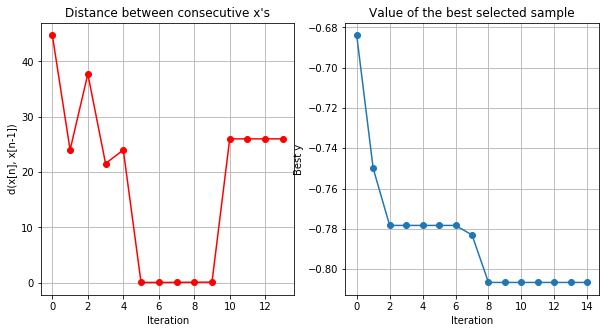

0

0

0

In [6]:
from GPyOpt.methods import BayesianOptimization
import subprocess
import sys
sys.setrecursionlimit(1500)

for i in range(len(models)):
    model_num = i
    for data_index, datadir in enumerate(('data/die_vs_all_11', 'data/4_class_11')):
        global iteration
        iteration = 0  # reset to 0
        
        DATA_DIR = datadir
        print(datadir.upper())
        NUM_CLASSES = 2 * (data_index+1)
    
        try:
            problem = BayesianOptimization(
                f=f,
                domain=domain
            )
            problem.run_optimization(max_iter=10)
            problem.plot_acquisition()
            problem.plot_convergence()
        
        except Exception as e:
            print('Skipping because', e)
#             import traceback
#             traceback.print_exc()
            continue
            
        # commit & push only if we can connect to internet
        subprocess.check_call(['git', 'add', 'experiments'])
        subprocess.check_call(['git', 'commit', '-am', f'Results from {str(models[i]).split()[1]} {datadir}'])
        subprocess.check_call(['git', 'push'])

In [9]:
subprocess.check_call(["spd-say", "Your code has finished running"])
subprocess.check_call(['git', 'commit', '-am', "BO final commit"])
subprocess.check_call(['git', 'push'])


0

0

0